In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import cos, sin, pi, sqrt, real, imag, matmul
from scipy.fft import fft, fftfreq

In [3]:
import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1, style='white')
sns.set_style("ticks", {"xtick.major.size": 1.5, "ytick.major.size": 1.5, 
                        "xtick.direction": "in","ytick.direction": "in"})
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('font', family='serif', serif='Times New Roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('legend',fontsize=8)
cmap = sns.color_palette(n_colors=10)

# I want to visualize DD and DDESEEM density matrix.

In [4]:
I = np.identity(2)
sigm_z = np.array([[1., 0.], [0., -1.]])
sigm_y = np.array([[0., -1j], [1j, 0.]])
sigm_x = np.array([[0., 1.], [1., 0.]])
sigm = np.array([sigm_x, sigm_y, sigm_z])

def Uop(angvec): # Build the unitary operator from the roatation angle and vector
    ang, n = angvec[0], angvec[1:]
    U = cos(ang)*I-1j*sin(ang)*(n[0]*sigm_x +n[1]*sigm_y +n[2]*sigm_z)
    return np.matrix(U)

def AngVec(U): # finds the rotation angle and vector of an unitary operator
    ang = np.arccos(0.5*np.trace(U))
    nx = 0.5j*np.trace(matmul(U, sigm_x))/sin(ang)
    ny = 0.5j*np.trace(matmul(U, sigm_y))/sin(ang)
    nz = 0.5j*np.trace(matmul(U, sigm_z))/sin(ang)
    n = real([nx, ny, nz])
    n = real( n/np.sqrt(np.sum(n*n,axis=0)))
    return np.array([real(ang), n[0], n[1], n[2]])
    
def mulAng(op2, op1): # angle of multiplied operator
    ang1,n1 = op1[0],op1[1:]
    ang2,n2 = op2[0],op2[1:]
    dot = np.sum(n1*n2, axis=0)/np.sum(n1*n1, axis=0)/np.sum(n2*n2, axis=0)
    return np.arccos(cos(ang1)*cos(ang2)-dot*sin(ang1)*sin(ang2))

def mulVec(op2, op1):
    ang1,n1 = op1[0],op1[1:]
    ang2,n2 = op2[0],op2[1:]
    ang = mulAng(op2, op1)
    cross21 = np.array([n2[1]*n1[2]-n2[2]*n1[1], n2[2]*n1[0]-n2[0]*n1[2], n2[0]*n1[1]-n2[1]*n1[0]])
    n = sin(ang1)*cos(ang2)*n1+sin(ang2)*cos(ang1)*n2-sin(ang1)*sin(ang2)*cross21
    n = n/sin(ang)
    return np.array([ang, n[0],n[1],n[2]])
    
#################################### This is true only for spin1/2 but it is faster!###################
def Uop2(angvec): # Build the unitary operator from the roatation angle and vector
    ang, [nx, ny, nz] = angvec
    U = np.array([[cos(ang)-1j*nz*sin(ang), -1j*nx*sin(ang)-ny*sin(ang)],
                 [-1j*nx*sin(ang)+ny*sin(ang), cos(ang)+1j*nz*sin(ang)]])
    return U

def AngVec2(U): # finds the rotation angle and vector of an unitary operator
    ang = np.arccos(real(U[0,0]))
    nx = -imag(U[0,1])/sin(ang)
    ny = -real(U[0,1])/sin(ang)
    nz = -imag(U[0,0])/sin(ang)
    n = real(np.array([nx, ny, nz]))
    return [real(ang), n/np.linalg.norm(n)]
############################################################################################################
def Generate_noisy_signal(p, N_meas): # p=1 bright state, p=0 dark state probability
    projection = np.random.binomial(np.ones_like(p,dtype=int),p, size=(N_meas,p.shape[0]))
    average_proj = np.sum(projection, axis=0)
    emit_bright, emit_dark = 3, 0.1 # every measurement how many photons is detected on average
    n_bright = np.random.poisson(average_proj*emit_bright)
    n_dark = np.random.poisson((N_meas-average_proj)*emit_dark)
    n_total = n_bright+n_dark
    return n_total/(N_meas*emit_bright) # noisy probability of bright state

In [5]:
def Hahn_echo(fL, Azz, Azx, tau, s1=1, s0=0): #Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    ang_V0 = np.arccos(cos(Ome0*tau/2)*cos(Ome1*tau/2)-dot *sin(Ome0*tau/2)*sin(Ome1*tau/2))
    n_V0 = np.array([cos(Ome1*tau/2)*sin(Ome0*tau/2)*mx +cos(Ome0*tau/2)*sin(Ome1*tau/2)*nx,
                     -sin(Ome1*tau/2)*sin(Ome0*tau/2)*q,
                    cos(Ome1*tau/2)*sin(Ome0*tau/2)*mz +cos(Ome0*tau/2)*sin(Ome1*tau/2)*nz])
    n_V0 = n_V0/np.sqrt(np.sum(n_V0*n_V0, axis=0))
    
    
    V0 = np.array([ang_V0, n_V0[0], n_V0[1], n_V0[2]])
    V1d = np.array([ang_V0, -n_V0[0], n_V0[1], -n_V0[2]]) 
    sigma_z = cos(mulAng(V0, V1d))
    return -np.prod(sigma_z)


def DD(fL, Azz, Azx, tau, N, s1=1, s0=-1): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 = n_VD0/np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 = n_VD1/np.sqrt(np.sum(n_VD1*n_VD1,axis=0))

    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    sigma_z = cos(mulAng(VD0, VD1d))
    #sigma_z = 1-(1-np.sum(n_VD0*n_VD1,axis=0))*sin(ang_VD0)**2
    return -np.prod(sigma_z)

def anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    one_minus_dot = q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(Thet))
    sigma_z = 1-one_minus_dot*sin(N_pi/2*Thet)**2
    return -np.prod(sigma_z)

In [6]:
def anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1): ## Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome_a = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome_b = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome_a, (OmeL+s0*Azz)/Ome_a
    nx, nz = s1*Azx/Ome_b, (OmeL+s1*Azz)/Ome_b
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome_a/Ome_b
    q = (s1-s0)*OmeL*Azx/Ome_a/Ome_b
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome_a/Ome_b
    

    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    Eta_a = np.arctan2(s0*Azx, OmeL+s0*Azz)     ## specific for spin 1/2
    Eta_b = np.arctan2(s1*Azx, OmeL+s1*Azz)    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2

    E_2p_tau1 = 1-K/2 + K/2*(cos(Ome_a*tau1) +cos(Ome_b*tau1) 
                              -0.5*cos(Ome_minu*tau1) -0.5*cos(Ome_plus*tau1))
    E_2p_tau2 = 1-K/2 + K/2*(cos(Ome_a*tau2) +cos(Ome_b*tau2) 
                              -0.5*cos(Ome_minu*tau2) -0.5*cos(Ome_plus*tau2))

    term1 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term2 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term3 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) ) 

    term4 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) )
    
    
    signal = 0.25*(np.prod(term1) - np.prod(term2) + np.prod(term3) -np.prod(term4))
    return signal

def eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1): ## Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    ang_V0 = np.arccos(cos(Ome0*tau1/2)*cos(Ome1*tau1/2)-dot *sin(Ome0*tau1/2)*sin(Ome1*tau1/2))
    n_V0 = np.array([cos(Ome1*tau1/2)*sin(Ome0*tau1/2)*mx +cos(Ome0*tau1/2)*sin(Ome1*tau1/2)*nx,
                     -sin(Ome1*tau1/2)*sin(Ome0*tau1/2)*q,
                    cos(Ome1*tau1/2)*sin(Ome0*tau1/2)*mz +cos(Ome0*tau1/2)*sin(Ome1*tau1/2)*nz])
    n_V0 /=np.sqrt(np.sum(n_V0*n_V0, axis=0))
        
    ang_W0 = np.arccos(cos(Ome0*tau2/2)*cos(Ome1*tau2/2)-dot *sin(Ome0*tau2/2)*sin(Ome1*tau2/2))
    n_W0 = np.array([cos(Ome1*tau2/2)*sin(Ome0*tau2/2)*mx +cos(Ome0*tau2/2)*sin(Ome1*tau2/2)*nx,
                     -sin(Ome1*tau2/2)*sin(Ome0*tau2/2)*q,
                    cos(Ome1*tau2/2)*sin(Ome0*tau2/2)*mz +cos(Ome0*tau2/2)*sin(Ome1*tau2/2)*nz])
    n_W0 /=np.sqrt(np.sum(n_W0*n_W0, axis=0))
    
    
    V0 = np.array([ang_V0, n_V0[0], n_V0[1], n_V0[2]])
    V1d = np.array([ang_V0, -n_V0[0], n_V0[1], -n_V0[2]])
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])    
    W0 = np.array([ang_W0, n_W0[0], n_W0[1], n_W0[2]])
    W1 = np.array([ang_W0, n_W0[0], -n_W0[1], n_W0[2]])
    
    V0V1d= mulVec(V0, V1d)
    W0F0 = mulVec(W0, F0)
    W0F1 = mulVec(W0, F1)
    W1F0 = mulVec(W1, F0)
    W1F1 = mulVec(W1, F1)
    
    W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(W0F0, V0V1d), np.array([W1F0[0], -W1F0[1], -W1F0[2], -W1F0[3]]))))
    W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(W1F0, V0V1d), np.array([W0F0[0], -W0F0[1], -W0F0[2], -W0F0[3]]))))
    W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(W0F1, V0V1d), np.array([W1F1[0], -W1F1[1], -W1F1[2], -W1F1[3]]))))
    W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(W1F1, V0V1d), np.array([W0F1[0], -W0F1[1], -W0F1[2], -W0F1[3]])))) 
    return -0.25*(W1F1V0V1dF1dW0d - W0F1V0V1dF1dW1d + W1F0V0V1dF0dW0d - W0F0V0V1dF0dW1d)


In [7]:
def ddeseem(fL, Azz, Azx, tau1, tau2, tc, N, s1=1, s0=-1): ## N must be even, Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome0/Ome1
    
    tau = tau1
    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 /=np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 /=np.sqrt(np.sum(n_VD1*n_VD1,axis=0))
    
    tau=tau2
    ang_WD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_WD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_WD0 /=np.sqrt(np.sum(n_WD0*n_WD0,axis=0))
    
    n_WD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_WD1 /=np.sqrt(np.sum(n_WD1*n_WD1,axis=0))
    
    
    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])    
    WD0 = np.array([ang_WD0, n_WD0[0], n_WD0[1], n_WD0[2]])
    WD0d = np.array([ang_WD0, -n_WD0[0], -n_WD0[1], -n_WD0[2]])
    WD1 = np.array([ang_WD0, n_WD1[0], n_WD1[1], n_WD1[2]])
    WD1d = np.array([ang_WD0, -n_WD1[0], -n_WD1[1], -n_WD1[2]])
    
    VD0VD1d= mulVec(VD0, VD1d)
    WD0F0 = mulVec(WD0, F0)
    WD0F1 = mulVec(WD0, F1)
    WD1F0 = mulVec(WD1, F0)
    WD1F1 = mulVec(WD1, F1)
    
    W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(WD0F0, VD0VD1d), np.array([WD1F0[0], -WD1F0[1], -WD1F0[2], -WD1F0[3]]))))
    W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(WD1F0, VD0VD1d), np.array([WD0F0[0], -WD0F0[1], -WD0F0[2], -WD0F0[3]]))))
    W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(WD0F1, VD0VD1d), np.array([WD1F1[0], -WD1F1[1], -WD1F1[2], -WD1F1[3]]))))
    W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(WD1F1, VD0VD1d), np.array([WD0F1[0], -WD0F1[1], -WD0F1[2], -WD0F1[3]]))))

#     F0d = np.array([Ome0*tc/2, -mx, np.zeros_like(Azz, dtype=float), -mz])
#     F1d = np.array([Ome1*tc/2, -nx, np.zeros_like(Azz, dtype=float), -nz])
#     F0dWD1d = mulVec(F0d, WD1d)
#     F0dWD0d = mulVec(F0d, WD0d)
#     F1dWD1d = mulVec(F1d, WD1d)
#     F1dWD0d = mulVec(F1d, WD0d)
    
#     W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(WD0F0, VD0VD1d), F0dWD1d)))
#     W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(WD1F0, VD0VD1d), F0dWD0d)))
#     W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(WD0F1, VD0VD1d), F1dWD1d)))
#     W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(WD1F1, VD0VD1d), F1dWD0d)))
    return -0.25*(W1F1V0V1dF1dW0d - W0F1V0V1dF1dW1d + W1F0V0V1dF0dW0d - W0F0V0V1dF0dW1d)

In [449]:
# determining the parameters
fL = 4003.4983*1.0705 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([-20.72, -23.22, -31.25, -14.07, -11.346, -48.58, -8.32, -9.79, 213.154, 17.643, 14.548, 20.569, 8.029,
               -19.815, -13.961, -4.66, -5.62, -36.308, 24.399, 2.69, 1.212, 7.683, -3.177]) # kHz
Azx = np.array([12, 13, 8, 13, 59.21, 9, 3, 5, 3, 8.6, 10, 41.51, 21, 5.3, 9, 7, 5, 26.62, 24.81, 11, 13, 4, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

Freq Larmor=4285.74493015 kHz
Azz=[-20.72  -23.22  -31.25  -14.07  -11.346 -48.58   -8.32   -9.79  213.154
  17.643  14.548  20.569   8.029 -19.815 -13.961  -4.66   -5.62  -36.308
  24.399   2.69    1.212   7.683  -3.177] kHz
Azx=[12.   13.    8.   13.   59.21  9.    3.    5.    3.    8.6  10.   41.51
 21.    5.3   9.    7.    5.   26.62 24.81 11.   13.    4.    2.  ] kHz
Freq hyp up=[4265.04181161 4262.54475403 4254.5024516  4271.69471157 4274.80900605
 4237.17448842 4277.42598218 4275.95785347 4498.89993039 4303.39652337
 4300.30455725 4306.51398989 4293.82528327 4265.93322251 4271.79341096
 4281.09065299 4280.12785062 4249.52030796 4310.21533507 4288.44903784
 4286.97664106 4293.42979346 4282.56839716] kHz
Blind Spot up=[0.23446429 0.23460164 0.23504511 0.23409913 0.23392858 0.23600633
 0.23378546 0.23386573 0.22227656 0.23237459 0.23254167 0.23220637
 0.23289257 0.2344153  0.23409372 0.23358534 0.23363788 0.23532068
 0.23200697 0.23318454 0.23326463 0.23291402 0.23350474] us
Freq h

In [9]:
def rho_DD(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 = n_VD0/np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 = n_VD1/np.sqrt(np.sum(n_VD1*n_VD1,axis=0))

    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]])
    VD0VD1d = mulVec(VD0, VD1d)
    tet = VD0VD1d[0]
    print('Rot Angle={} deg'.format(VD0VD1d[0]*180/pi))
    I = np.identity(2)
    rho_dd = np.zeros((4,4), dtype=complex)
    rho_dd[0:2, 0:2]= 2*(1-cos(tet))*I
    rho_dd[2:4, 2:4]= 2*(1+cos(tet))*I
    rho_dd[0:2, 2:4]= -2*(Uop(VD0VD1d) - cos(tet)*I)
    rho_dd[2:4, 0:2]= -rho_dd[0:2, 2:4]

    return rho_dd/8

# Density Matrix Visualization with Qiskit

Rot Angle=1.179624770103089 deg
$\tau$= 5.905889308799686 $\mu$s


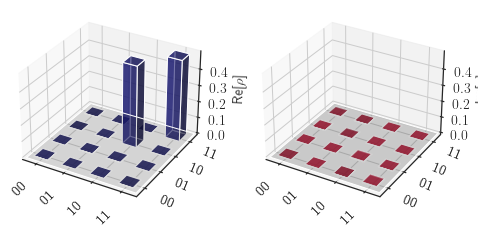

In [506]:
from qiskit.visualization import plot_state_city, plot_state_hinton
DD_res = 50.5*1/(fL+Fh_up)
tau = DD_res[0]
i=1
rho = rho_DD(fL, np.array(Azz[i]), np.array(Azx[i]), tau, 602, s1=1, s0=0)
print(r'$\tau$= {} $\mu$s'.format(tau*1000)) # in us
plot_state_city(rho, color=['midnightblue', 'crimson'], alpha=0.6, figsize=(8,4))

[[5.29830767e-05 0.00000000e+00 4.25207039e-06 5.14671867e-03]
 [0.00000000e+00 5.29830767e-05 5.14671867e-03 4.25207039e-06]
 [4.25207039e-06 5.14671867e-03 4.99947017e-01 0.00000000e+00]
 [5.14671867e-03 4.25207039e-06 0.00000000e+00 4.99947017e-01]]


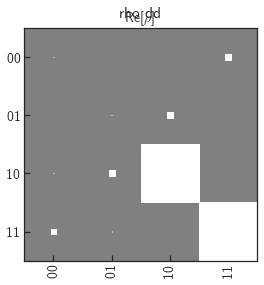

In [507]:
fig, ax = plt.subplots(1,1)
plot = plot_state_hinton(abs(rho), figsize=(6,3), ax_real=ax, title='rho dd')
print(abs(rho))

# Spin 1/2 system

In [550]:
fL = 4003.4983*1.0705 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([-20.72, -23.22, -31.25, -14.07, -11.346, -48.58, -8.32, -9.79, 213.154, 17.643, 14.548, 20.569, 8.029,
               -19.815, -13.961, -4.66, -5.62, -36.308, 24.399, 2.69, 1.212, 7.683, -3.177]) # kHz
Azx = np.array([12, 13, 8, 13, 59.21, 9, 3, 5, 3, 8.6, 10, 41.51, 21, 5.3, 9, 7, 5, 26.62, 24.81, 11, 13, 4, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn

Rot Angle=89.04717575434418 deg


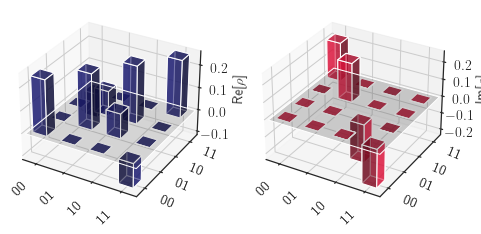

In [511]:
from qiskit.visualization import plot_state_city, plot_state_hinton

DD_res = 50.5*1/(Fh_dn+Fh_up)
tau = DD_res[1]
rho = rho_DD(fL, np.array(Azz[0]), np.array(Azx[0]), tau, 616, s1=0.5, s0=-0.5)
plot_state_city(rho, color=['midnightblue', 'crimson'], alpha=0.6, figsize=(8,4))

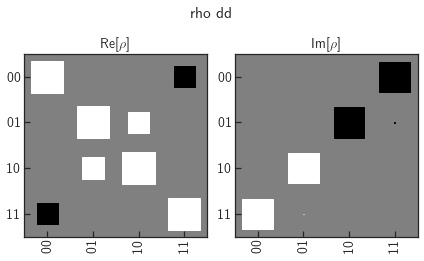

In [512]:
fig, ax = plt.subplots(1,2)
plot = plot_state_hinton(rho, figsize=(6,3), ax_real=ax[0], ax_imag=ax[1], title='rho dd')

In [133]:
def rho_ddeseem(fL, Azz, Azx, tau1, tau2, tc, N1, N2, s1=1, s0=-1): ## N must be even, Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    tau = tau1
    ang_VD0 = N1/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 /=np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 /=np.sqrt(np.sum(n_VD1*n_VD1,axis=0))
    
    tau=tau2
    ang_WD0 = N2/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_WD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_WD0 /=np.sqrt(np.sum(n_WD0*n_WD0,axis=0))
    
    n_WD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_WD1 /=np.sqrt(np.sum(n_WD1*n_WD1,axis=0))
    
    
    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])
    F0d = np.array([Ome0*tc/2, -mx, np.zeros_like(Azz, dtype=float), -mz])
    F1d = np.array([Ome1*tc/2, -nx, np.zeros_like(Azz, dtype=float), -nz])
    WD0 = np.array([ang_WD0, n_WD0[0], n_WD0[1], n_WD0[2]])
    WD0d = np.array([ang_WD0, -n_WD0[0], -n_WD0[1], -n_WD0[2]])
    WD1 = np.array([ang_WD0, n_WD1[0], n_WD1[1], n_WD1[2]])
    WD1d = np.array([ang_WD0, -n_WD1[0], -n_WD1[1], -n_WD1[2]])
    
    
    VD0VD1d= mulVec(VD0, VD1d)
    WD0F0 = mulVec(WD0, F0)
    WD0F1 = mulVec(WD0, F1)
    WD1F0 = mulVec(WD1, F0)
    WD1F1 = mulVec(WD1, F1)
    
    I = np.identity(2)
    tet1 = VD0VD1d[0]
    print('Rot Angle 1 = {} deg'.format(tet1*180/pi))
    rho6 = np.zeros((4,4), dtype=complex)
    rho6[0:2, 0:2]= 2*I -2j*(Uop(VD0VD1d) - cos(tet1)*I)
    rho6[2:4, 2:4]= 2*I +2j*(Uop(VD0VD1d) - cos(tet1)*I)
    rho6[0:2, 2:4]= 2*cos(tet1)*I
    rho6[2:4, 0:2]= rho6[0:2, 2:4]
    
    F1VD0VD1dF1d = mulVec(mulVec(F1, VD0VD1d), F1d)
    F0VD0VD1dF0d = mulVec(mulVec(F0, VD0VD1d), F0d)
    rho7 = np.zeros((4,4), dtype=complex)
    rho7[0:2, 0:2]= 2*I -2j*(Uop(F1VD0VD1dF1d) - cos(tet1)*I)
    rho7[2:4, 2:4]= 2*I +2j*(Uop(F0VD0VD1dF0d) - cos(tet1)*I)
    
    rho8 = np.matmul(np.matmul(pi_2y_e, rho7),pi_2y_e.getH())

    
    tet2= np.arccos(cos(ang_WD0)**2+sin(ang_WD0)**2 *np.sum(n_WD0*n_WD1, axis=0))
    print('Rot Angle 2 = {} deg'.format(tet2*180/pi))
    
    
    W0F0V0V1dF0dW1d = Uop(mulVec(mulVec(WD0F0, VD0VD1d), np.array([WD1F0[0], -WD1F0[1], -WD1F0[2], -WD1F0[3]])))
    W1F0V0V1dF0dW0d = Uop(mulVec(mulVec(WD1F0, VD0VD1d), np.array([WD0F0[0], -WD0F0[1], -WD0F0[2], -WD0F0[3]])))
    W0F1V0V1dF1dW1d = Uop(mulVec(mulVec(WD0F1, VD0VD1d), np.array([WD1F1[0], -WD1F1[1], -WD1F1[2], -WD1F1[3]])))
    W1F1V0V1dF1dW0d = Uop(mulVec(mulVec(WD1F1, VD0VD1d), np.array([WD0F1[0], -WD0F1[1], -WD0F1[2], -WD0F1[3]])))
    W0F0V0V1dF0dW0d = Uop(mulVec(mulVec(WD0F0, VD0VD1d), np.array([WD0F0[0], -WD0F0[1], -WD0F0[2], -WD0F0[3]])))
    W1F0V0V1dF0dW1d = Uop(mulVec(mulVec(WD1F0, VD0VD1d), np.array([WD1F0[0], -WD1F0[1], -WD1F0[2], -WD1F0[3]])))
    W0F1V0V1dF1dW0d = Uop(mulVec(mulVec(WD0F1, VD0VD1d), np.array([WD0F1[0], -WD0F1[1], -WD0F1[2], -WD0F1[3]])))
    W1F1V0V1dF1dW1d = Uop(mulVec(mulVec(WD1F1, VD0VD1d), np.array([WD1F1[0], -WD1F1[1], -WD1F1[2], -WD1F1[3]])))
    
    a = 4*I -2*(W1F1V0V1dF1dW1d-cos(VD0VD1d[0])*I) -2*(W1F0V0V1dF0dW1d-cos(VD0VD1d[0])*I)
    b = -1j*(W1F1V0V1dF1dW0d +W1F0V0V1dF0dW0d -W0F1V0V1dF1dW1d -W0F0V0V1dF0dW1d)
    c = b.getH()
    d = 4*I -2*(W0F1V0V1dF1dW0d-cos(VD0VD1d[0])*I) -2*(W0F0V0V1dF0dW0d-cos(VD0VD1d[0])*I)
    rho11 = np.zeros((4,4), dtype=complex)
    rho11[0:2, 0:2]= a
    rho11[2:4, 2:4]= d
    rho11[0:2, 2:4]= b
    rho11[2:4, 0:2]= c
    rho12 = np.zeros((4,4), dtype=complex)
    rho12[0:2, 0:2]= 0.5*(a+d+1j*(b-c))
    rho12[2:4, 2:4]= 0.5*(a+d-1j*(b-c))
    rho12[0:2, 2:4]= 0.5*(b+c+1j*(a-d))
    rho12[2:4, 0:2]= 0.5*(b+c-1j*(a-d))

    return [rho6/8, rho7/8, rho8/8, rho11/16, rho12/16]

In [182]:
pi_2y_e = np.zeros((4,4), dtype=complex)
pi_2y_e[0:2, 0:2]= I
pi_2y_e[2:4, 2:4]= I
pi_2y_e[0:2, 2:4]= -I
pi_2y_e[2:4, 0:2]= I
pi_2y_e = np.matrix(pi_2y_e/sqrt(2))
print(pi_2y_e)

pi_y_e = np.zeros((4,4), dtype=complex)
pi_y_e[0:2, 0:2]= 0
pi_y_e[2:4, 2:4]= 0
pi_y_e[0:2, 2:4]= -I
pi_y_e[2:4, 0:2]= I
pi_y_e = np.matrix(pi_y_e/sqrt(2))
print(pi_y_e)

pi_2x_e = np.zeros((4,4), dtype=complex)
pi_2x_e[0:2, 0:2]= I
pi_2x_e[2:4, 2:4]= I
pi_2x_e[0:2, 2:4]= -1j*I
pi_2x_e[2:4, 0:2]= -1j*I
pi_2x_e = np.matrix(pi_2x_e/sqrt(2))
print(pi_2x_e)

[[ 0.70710678+0.j  0.        +0.j -0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j -0.70710678+0.j]
 [ 0.70710678+0.j  0.        +0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j  0.70710678+0.j]]
[[ 0.        +0.j  0.        +0.j -0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -0.70710678+0.j]
 [ 0.70710678+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]]
[[0.70710678+0.j         0.        +0.j         0.        -0.70710678j
  0.        -0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        -0.j
  0.        -0.70710678j]
 [0.        -0.70710678j 0.        -0.j         0.70710678+0.j
  0.        +0.j        ]
 [0.        -0.j         0.        -0.70710678j 0.        +0.j
  0.70710678+0.j        ]]


Rot Angle=89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg


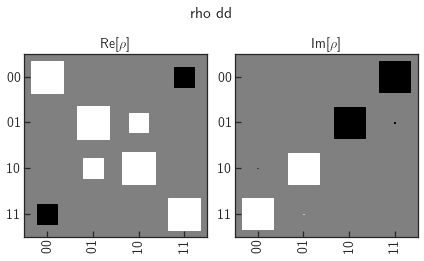

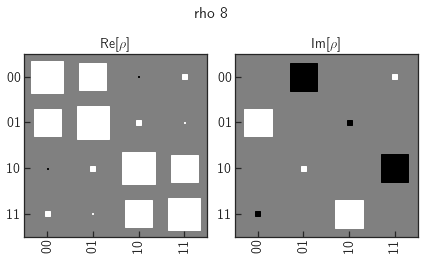

In [180]:
DD_res = 50.5*1/(Fh_dn+Fh_up)
tau1=tau2= DD_res[0]
tc=101.18/fL
#tc=1.110141
N1=616
N2=616
fig, ax = plt.subplots(1,2)
rho = rho_DD(fL, np.array(Azz[0]), np.array(Azx[0]), tau1, N1, s1=0.5, s0=-0.5)
plot = plot_state_hinton(rho, figsize=(6,3), ax_real=ax[0], ax_imag=ax[1], title='rho dd')

[rho6, rho7, rho8, rho11, rho12] = rho_ddeseem(fL, np.array(Azz[0]), np.array(Azx[0]), tau1, tau2, tc, N1, N2, s1=0.5, s0=-0.5)

# fig, ax = plt.subplots(1,2)
# plot = plot_state_hinton(rho6, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1], title='rho 6')
# fig, ax = plt.subplots(1,2)
# plot = plot_state_hinton(rho7, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1], title='rho 7')
fig, ax = plt.subplots(1,2)
plot = plot_state_hinton(rho8, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1], title='rho 8')
# fig, ax = plt.subplots(1,2)
# plot = plot_state_hinton(rho11, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1],title='rho 11')
# fig, ax = plt.subplots(1,2)
# plot = plot_state_hinton(rho12, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1], title='rho 12')
# fig, ax = plt.subplots(1,2)
# rho_ent = np.matmul(np.matmul(pi_2y_e, rho12),pi_2y_e.getH())
# plot = plot_state_hinton(rho_ent, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1],title='rho 12+ piy/2')

Rot Angle=85.34663771145932 deg
Rot Angle 1 = 85.34663771145932 deg
Rot Angle 2 = 85.34663771145932 deg


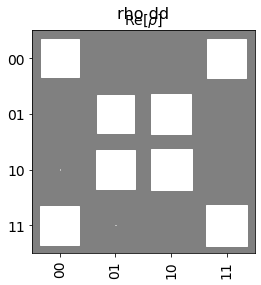

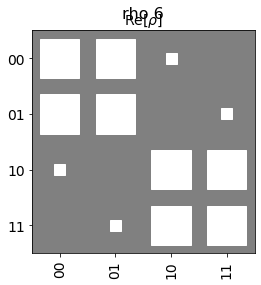

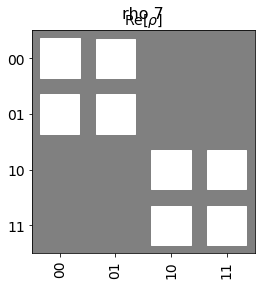

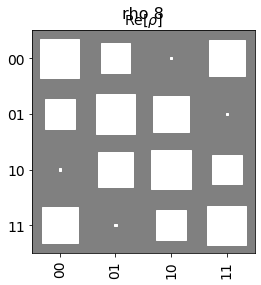

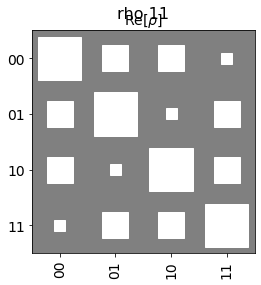

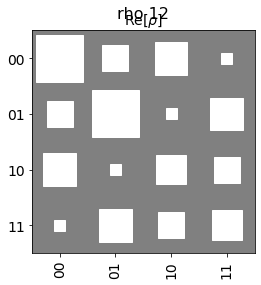

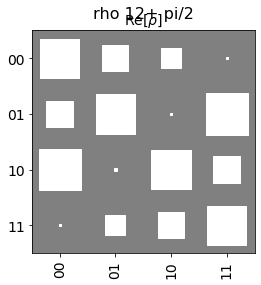

In [360]:
DD_res = 0.5*1/(Fh_dn+Fh_up)
tau1=tau2= 1*DD_res[11]
tc=4/fL
#tc=1.110141
N1=56
N2=56
fig, ax = plt.subplots()
rho = rho_DD(fL, np.array(Azz[0]), np.array(Azx[0]), tau1, N1, s1=0.5, s0=-0.5)
plot = plot_state_hinton(np.abs(rho), figsize=(6,3), ax_real=ax, title='rho dd')

[rho6, rho7, rho8, rho11, rho12] = rho_ddeseem(fL, np.array(Azz[0]), np.array(Azx[0]), tau1, tau2, tc, N1, N2, s1=0.5, s0=-0.5)

fig, ax = plt.subplots()
plot = plot_state_hinton(np.abs(rho6), figsize=(6,3), ax_real=ax, title='rho 6')
fig, ax = plt.subplots()
plot = plot_state_hinton(np.abs(rho7), figsize=(6,3), ax_real=ax, title='rho 7')
fig, ax = plt.subplots()
plot = plot_state_hinton(np.abs(rho8), figsize=(6,3), ax_real=ax, title='rho 8')
fig, ax = plt.subplots()
plot = plot_state_hinton(np.abs(rho11), figsize=(6,3), ax_real=ax, title='rho 11')
fig, ax = plt.subplots()
plot = plot_state_hinton(np.abs(rho12), figsize=(6,3), ax_real=ax, title='rho 12')
fig, ax = plt.subplots()
rho_ent = np.matmul(np.matmul(pi_2y_e, rho12),pi_2y_e.getH())
plot = plot_state_hinton(np.abs(rho_ent), figsize=(6,3), ax_real=ax,title='rho 12+ pi/2')

Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001128 deg
Rot Angle 1 = 89.91053527001128 deg
Rot Angle 2 = 89.91053527001

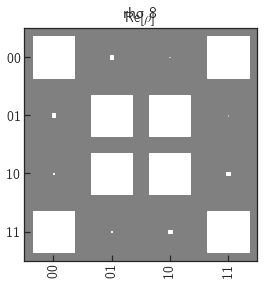

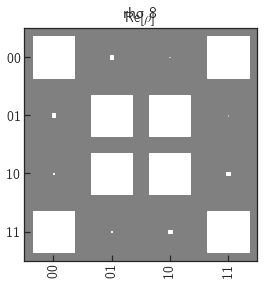

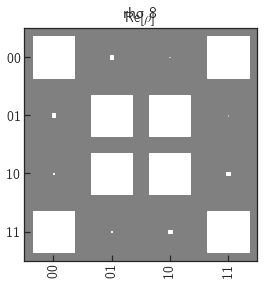

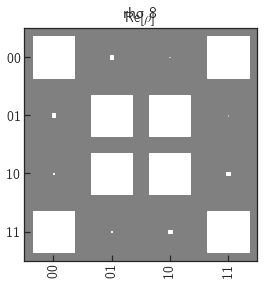

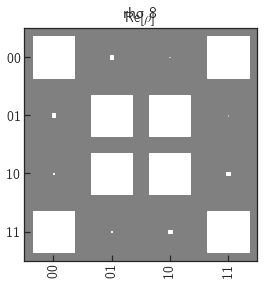

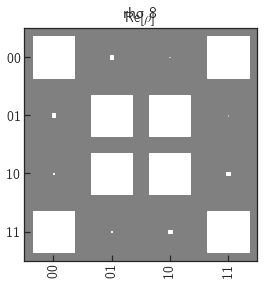

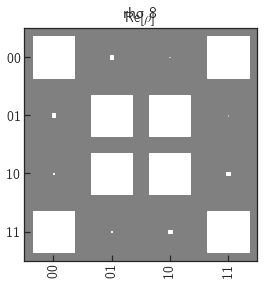

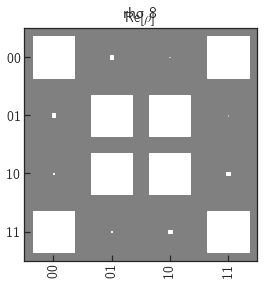

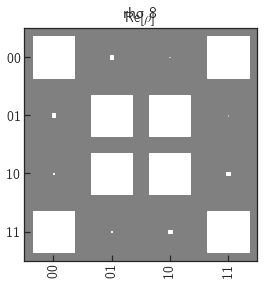

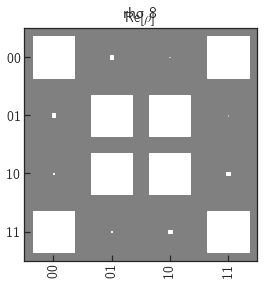

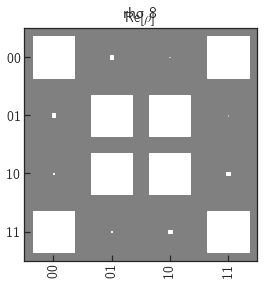

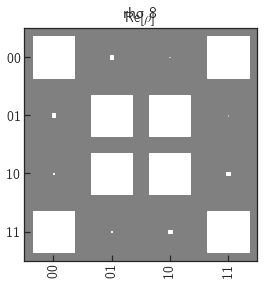

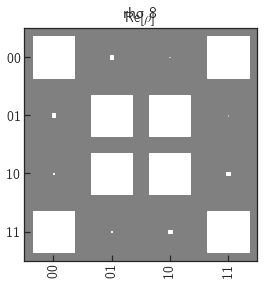

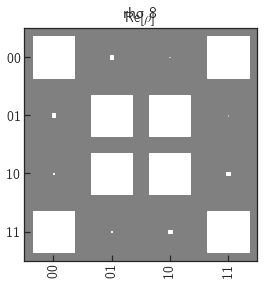

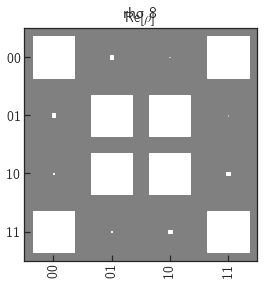

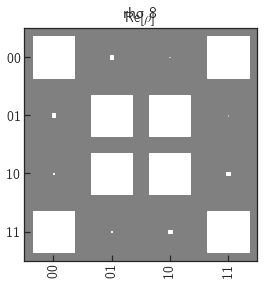

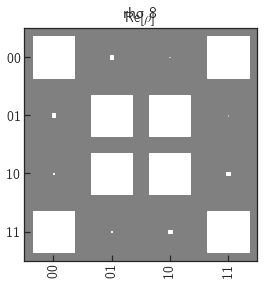

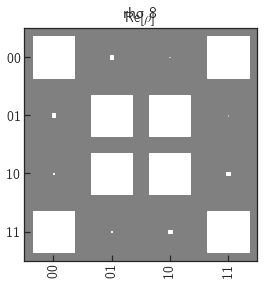

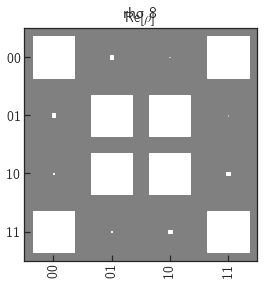

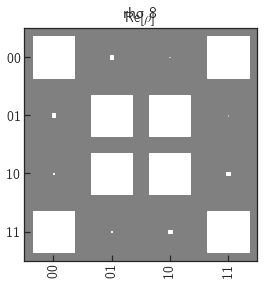

In [162]:
for tc in np.linspace(1.110140, 1.110142, 20):
    [rho6, rho7, rho8, rho11, rho12] = rho_ddeseem(fL, np.array(Azz[0]), np.array(Azx[0]), tau1, tau2, tc, N1, N2, s1=0.5, s0=-0.5)
    fig, ax = plt.subplots()
    plot = plot_state_hinton(np.abs(rho8), figsize=(6,3), ax_real=ax, title='rho 8')

In [184]:
def Gate_rho_ddeseem(fL, Azz, Azx, tau1, tc1, tc2, N1, s1=1, s0=-1): ## N must be even, Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    tau = tau1
    ang_VD0 = N1/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 /=np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 /=np.sqrt(np.sum(n_VD1*n_VD1,axis=0))
    
#     tau=tau2
#     ang_WD0 = N2/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
#     n_WD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
#                     np.zeros_like(Azz, dtype=float),
#                     sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
#     n_WD0 /=np.sqrt(np.sum(n_WD0*n_WD0,axis=0))
    
#     n_WD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
#                     np.zeros_like(Azz, dtype=float),
#                     sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
#     n_WD1 /=np.sqrt(np.sum(n_WD1*n_WD1,axis=0))
    
    
    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]])
    tc= tc1
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])
    F0d = np.array([Ome0*tc/2, -mx, np.zeros_like(Azz, dtype=float), -mz])
    F1d = np.array([Ome1*tc/2, -nx, np.zeros_like(Azz, dtype=float), -nz])
#     WD0 = np.array([ang_WD0, n_WD0[0], n_WD0[1], n_WD0[2]])
#     WD0d = np.array([ang_WD0, -n_WD0[0], -n_WD0[1], -n_WD0[2]])
#     WD1 = np.array([ang_WD0, n_WD1[0], n_WD1[1], n_WD1[2]])
#     WD1d = np.array([ang_WD0, -n_WD1[0], -n_WD1[1], -n_WD1[2]])
    
    
    VD0VD1d= mulVec(VD0, VD1d)
#     WD0F0 = mulVec(WD0, F0)
#     WD0F1 = mulVec(WD0, F1)
#     WD1F0 = mulVec(WD1, F0)
#     WD1F1 = mulVec(WD1, F1)
    
    I = np.identity(2)
    tet1 = VD0VD1d[0]
    print('Rot Angle = {} deg'.format(tet1*180/pi))
    rho6 = np.zeros((4,4), dtype=complex)
    rho6[0:2, 0:2]= 2*I -2j*(Uop(VD0VD1d) - cos(tet1)*I)
    rho6[2:4, 2:4]= 2*I +2j*(Uop(VD0VD1d) - cos(tet1)*I)
    rho6[0:2, 2:4]= 2*cos(tet1)*I
    rho6[2:4, 0:2]= rho6[0:2, 2:4]
    
    F1VD0VD1dF1d = mulVec(mulVec(F1, VD0VD1d), F1d)
    F0VD0VD1dF0d = mulVec(mulVec(F0, VD0VD1d), F0d)
    rho6p = np.zeros((4,4), dtype=complex)
    rho6p[0:2, 0:2]= 2*I -2j*(Uop(F1VD0VD1dF1d) - cos(tet1)*I)
    rho6p[2:4, 2:4]= 2*I +2j*(Uop(F0VD0VD1dF0d) - cos(tet1)*I)
    
    rho7p = np.matmul(np.matmul(pi_y_e, rho6p),pi_y_e.getH())
    
    tc= tc2
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])
    F0d = np.array([Ome0*tc/2, -mx, np.zeros_like(Azz, dtype=float), -mz])
    F1d = np.array([Ome1*tc/2, -nx, np.zeros_like(Azz, dtype=float), -nz])
    F0F1VD0VD1dF1dF0d = mulVec(mulVec(F0, F1VD0VD1dF1d), F0d)
    F1F0VD0VD1dF0dF1d = mulVec(mulVec(F1, F0VD0VD1dF0d), F1d)
    rho7 = np.zeros((4,4), dtype=complex)
    rho7[0:2, 0:2]= 2*I -2j*(Uop(F0F1VD0VD1dF1dF0d) - cos(tet1)*I)
    rho7[2:4, 2:4]= 2*I +2j*(Uop(F1F0VD0VD1dF0dF1d) - cos(tet1)*I)
    rho8 = np.matmul(np.matmul(pi_2y_e, rho7),pi_2y_e.getH())

    
#     tet2= np.arccos(cos(ang_WD0)**2+sin(ang_WD0)**2 *np.sum(n_WD0*n_WD1, axis=0))
#     print('Rot Angle 2 = {} deg'.format(tet2*180/pi))
    
    
#     W0F0V0V1dF0dW1d = Uop(mulVec(mulVec(WD0F0, VD0VD1d), np.array([WD1F0[0], -WD1F0[1], -WD1F0[2], -WD1F0[3]])))
#     W1F0V0V1dF0dW0d = Uop(mulVec(mulVec(WD1F0, VD0VD1d), np.array([WD0F0[0], -WD0F0[1], -WD0F0[2], -WD0F0[3]])))
#     W0F1V0V1dF1dW1d = Uop(mulVec(mulVec(WD0F1, VD0VD1d), np.array([WD1F1[0], -WD1F1[1], -WD1F1[2], -WD1F1[3]])))
#     W1F1V0V1dF1dW0d = Uop(mulVec(mulVec(WD1F1, VD0VD1d), np.array([WD0F1[0], -WD0F1[1], -WD0F1[2], -WD0F1[3]])))
#     W0F0V0V1dF0dW0d = Uop(mulVec(mulVec(WD0F0, VD0VD1d), np.array([WD0F0[0], -WD0F0[1], -WD0F0[2], -WD0F0[3]])))
#     W1F0V0V1dF0dW1d = Uop(mulVec(mulVec(WD1F0, VD0VD1d), np.array([WD1F0[0], -WD1F0[1], -WD1F0[2], -WD1F0[3]])))
#     W0F1V0V1dF1dW0d = Uop(mulVec(mulVec(WD0F1, VD0VD1d), np.array([WD0F1[0], -WD0F1[1], -WD0F1[2], -WD0F1[3]])))
#     W1F1V0V1dF1dW1d = Uop(mulVec(mulVec(WD1F1, VD0VD1d), np.array([WD1F1[0], -WD1F1[1], -WD1F1[2], -WD1F1[3]])))
    
#     a = 4*I -2*(W1F1V0V1dF1dW1d-cos(VD0VD1d[0])*I) -2*(W1F0V0V1dF0dW1d-cos(VD0VD1d[0])*I)
#     b = -1j*(W1F1V0V1dF1dW0d +W1F0V0V1dF0dW0d -W0F1V0V1dF1dW1d -W0F0V0V1dF0dW1d)
#     c = b.getH()
#     d = 4*I -2*(W0F1V0V1dF1dW0d-cos(VD0VD1d[0])*I) -2*(W0F0V0V1dF0dW0d-cos(VD0VD1d[0])*I)
#     rho11 = np.zeros((4,4), dtype=complex)
#     rho11[0:2, 0:2]= a
#     rho11[2:4, 2:4]= d
#     rho11[0:2, 2:4]= b
#     rho11[2:4, 0:2]= c
#     rho12 = np.zeros((4,4), dtype=complex)
#     rho12[0:2, 0:2]= 0.5*(a+d+1j*(b-c))
#     rho12[2:4, 2:4]= 0.5*(a+d-1j*(b-c))
#     rho12[0:2, 2:4]= 0.5*(b+c+1j*(a-d))
#     rho12[2:4, 0:2]= 0.5*(b+c-1j*(a-d))

    return [rho6/8, rho7/8, rho8/8]

Rot Angle=95.60830180448369 deg
Rot Angle = 95.60830180448369 deg


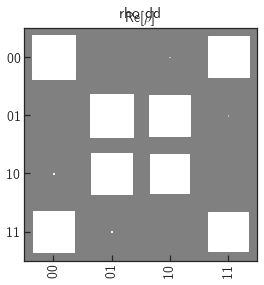

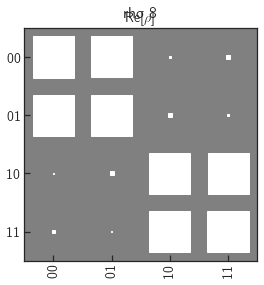

In [514]:
DD_res = 50.5*1/(Fh_dn+Fh_up)
tau1=tau2= DD_res[0]
tc1=101.048/fL
tc2 = tc1+24.1554290755*112
# tc1 = 1.110145/4
# tc2 = 1.110151/4
N1=616
i=1
fig, ax = plt.subplots(1,1)
rho = rho_DD(fL, np.array(Azz[i]), np.array(Azx[i]), tau1, N1, s1=0.5, s0=-0.5)
plot = plot_state_hinton(abs(rho), figsize=(6,3), ax_real=ax, title='rho dd')

[rho6, rho7, rho8] = Gate_rho_ddeseem(fL, np.array(Azz[i]), np.array(Azx[i]), tau1, tc1, tc2, N1, s1=0.5, s0=-0.5)

# fig, ax = plt.subplots(1,2)
# plot = plot_state_hinton(rho6, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1], title='rho 6')
# fig, ax = plt.subplots(1,2)
# plot = plot_state_hinton(rho7, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1], title='rho 7')
fig, ax = plt.subplots(1,1)
plot = plot_state_hinton(abs(rho8), figsize=(6,3), ax_real=ax, title='rho 8')
# fig, ax = plt.subplots(1,2)
# plot = plot_state_hinton(rho11, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1],title='rho 11')
# fig, ax = plt.subplots(1,2)
# plot = plot_state_hinton(rho12, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1], title='rho 12')
# fig, ax = plt.subplots(1,2)
# rho_ent = np.matmul(np.matmul(pi_2y_e, rho12),pi_2y_e.getH())
# plot = plot_state_hinton(rho_ent, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1],title='rho 12+ piy/2')

In [438]:
np.abs(rho8)

matrix([[0.25046422, 0.24879292, 0.00030185, 0.00220565],
        [0.24879292, 0.24953578, 0.00220565, 0.00030185],
        [0.00030185, 0.00220565, 0.25046422, 0.24879292],
        [0.00220565, 0.00030185, 0.24879292, 0.24953578]])

In [439]:
np.abs(rho)

array([[2.74431775e-01, 0.00000000e+00, 1.18919852e-04, 2.48803284e-01],
       [0.00000000e+00, 2.74431775e-01, 2.48803284e-01, 1.18919852e-04],
       [1.18919852e-04, 2.48803284e-01, 2.25568225e-01, 0.00000000e+00],
       [2.48803284e-01, 1.18919852e-04, 0.00000000e+00, 2.25568225e-01]])

Rot Angle = 89.91053527001128 deg
Rot Angle = 89.91053527001128 deg
Rot Angle = 89.91053527001128 deg
Rot Angle = 89.91053527001128 deg
Rot Angle = 89.91053527001128 deg
Rot Angle = 89.91053527001128 deg
Rot Angle = 89.91053527001128 deg
Rot Angle = 89.91053527001128 deg
Rot Angle = 89.91053527001128 deg
Rot Angle = 89.91053527001128 deg


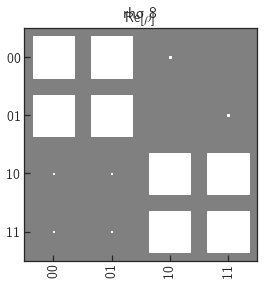

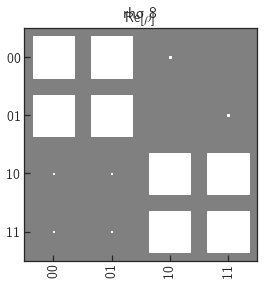

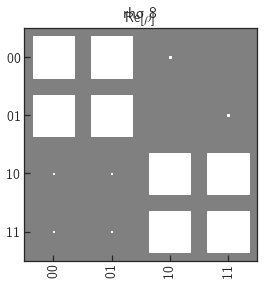

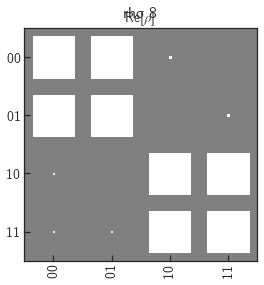

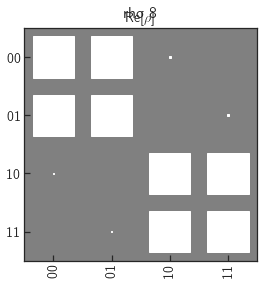

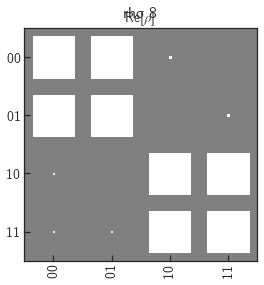

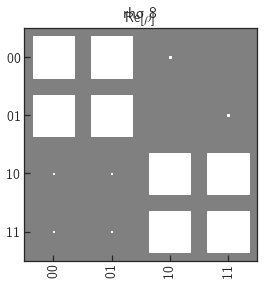

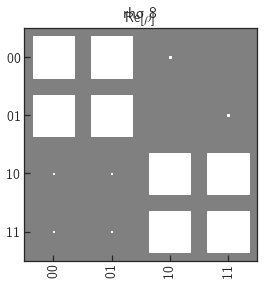

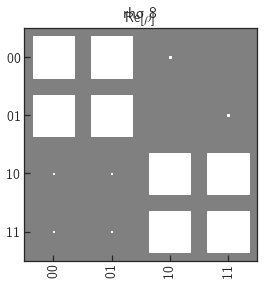

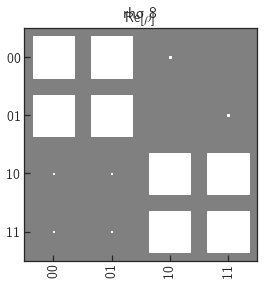

In [400]:
for add in np.linspace(0.024131296*1001, 0.0241313*1001, 10):
    [rho6, rho7, rho8] = Gate_rho_ddeseem(fL, np.array(Azz[i]), np.array(Azx[i]), tau1, tc, tc+add, N1, s1=0.5, s0=-0.5)
    fig, ax = plt.subplots()
    plot = plot_state_hinton(np.abs(rho8), figsize=(6,3), ax_real=ax, title='rho 8')

In [401]:
np.linspace(0.024131296*1001, 0.0241313*1001, 10)[4]

24.155429075555556

Rot Angle = 95.60830180448369 deg


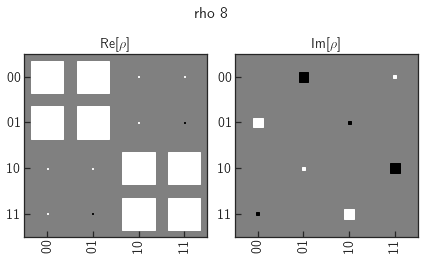

In [413]:
DD_res = 50.5*1/(Fh_dn+Fh_up)
tau1=tau2= DD_res[0]
tc1=101.048/fL
# tc2 = tc1+24.1554290755*1002
# tc1 = 1.110145/4
# tc2 = 1.110151/4
N1=616
i=1
for times in np.arange(112, 114, 18):
    tc2 = tc1+24.1554290755*times
    [rho6, rho7, rho8] = Gate_rho_ddeseem(fL, np.array(Azz[i]), np.array(Azx[i]), tau1, tc1, tc2, N1, s1=0.5, s0=-0.5)
    fig, ax = plt.subplots(1,2)
    plot = plot_state_hinton(rho8, figsize=(6,3), ax_real=ax[0], ax_imag= ax[1], title='rho 8')


# 2 qubit density matrix for DD gate

In [1224]:
import qutip as qt

def Gate_Nqbit_dd(fL, Azz, Azx, tau, N, s1=0.5, s0=-0.5): ## N must be even, Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 /=np.sqrt(np.sum(n_VD0*n_VD0,axis=0))

    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 /=np.sqrt(np.sum(n_VD1*n_VD1,axis=0))
    
    
    for i, azz in enumerate(Azz): 
        VD0 = np.array([ang_VD0[i], n_VD0[0,i], n_VD0[1,i], n_VD0[2,i]])
        VD1d = np.array([ang_VD0[i], -n_VD1[0,i], -n_VD1[1,i], -n_VD1[2,i]])
        VD0VD1d= mulVec(VD0, VD1d)
        print('Rot angle of nuc {}'.format(i)+'= {} deg'.format(VD0VD1d[0]*180/pi))
        VD0VD1d_op = qt.Qobj(Uop(VD0VD1d))
        if i==0:
            VD0VD1d_s = VD0VD1d_op/2 # devided by 2 due to nuclear spin initially in thermal state
            Id = qt.identity(2)/2 # devided by 2 due to nuclear spin initially in thermal state
        else:
            VD0VD1d_s = qt.tensor(VD0VD1d_s, VD0VD1d_op/2) # devided by 2 due to nuclear spin initially in thermal state
            Id = qt.tensor(Id, qt.identity(2)/2) # devided by 2 due to nuclear spin initially in thermal state
    VD0VD1d_s_dag = VD0VD1d_s.dag()
    d = 2**len(Azz)
    rho = np.identity(2*d, dtype=complex)
    rho[0:1*d, 0:1*d] = (2*Id - VD0VD1d_s - VD0VD1d_s_dag)/4
    rho[0:1*d, d:2*d] = -(VD0VD1d_s - VD0VD1d_s_dag)/4
    rho[d:2*d, 0:1*d] = (VD0VD1d_s - VD0VD1d_s_dag)/4
    rho[d:2*d, d:2*d] = (2*Id + VD0VD1d_s + VD0VD1d_s_dag)/4
    return qt.Qobj(rho)

Rot angle of nuc 0= 89.97387394840106 deg
Rot angle of nuc 1= 1.179624770103089 deg


Text(0.5, 1.0, 'DD Spin 1')

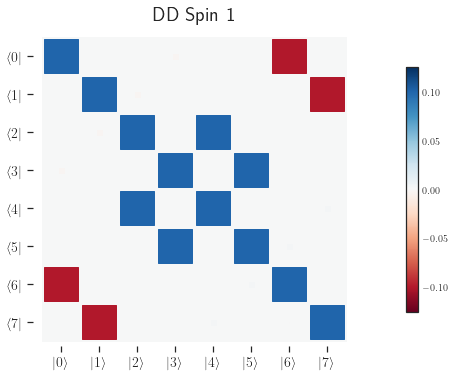

In [1392]:
DD_res = 50.5*1/(fL+Fh_up)
tau = DD_res[0]
rho_dd = Gate_Nqbit_dd(fL, Azz[0:2:1], Azx[0:2:1], tau, 602, s1=1, s0=0)
fig, ax = qt.visualization.hinton(rho_dd,
#                                   xlabels=['000','001','010','011','100','101','110','111'],
#                                   ylabels=['000','001','010','011','100','101','110','111'],
                                 label_top = False)
ax.set_title('DD Spin 1', fontsize=20)

In [753]:
(rho_dd*rho_dd).tr()

0.25

In [939]:
rho_dd.ptrace(0)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.24943016e-01+0.00000000e+00j -2.10952458e-06-8.20601480e-07j
   2.12603205e-06-2.98951353e-09j -2.39960256e-03-9.29558670e-04j
   0.00000000e+00-1.09926883e-04j -4.25403745e-07+1.09358766e-06j
  -1.75730860e-04-1.24973324e-01j  0.00000000e+00+0.00000000e+00j]
 [-2.10952458e-06+8.20601480e-07j  1.24943012e-01+0.00000000e+00j
  -2.39697888e-03+9.36303369e-04j -2.12603205e-06+2.98951353e-09j
   4.25403745e-07+1.09358766e-06j  0.00000000e+00-1.09924944e-04j
   0.00000000e+00+0.00000000e+00j -1.75730860e-04-1.24973324e-01j]
 [ 2.12603205e-06+2.98951353e-09j -2.39697888e-03-9.36303369e-04j
   1.24943012e-01+0.00000000e+00j  2.10952458e-06+8.20601480e-07j
   1.75730860e-04-1.24973324e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+1.09924944e-04j -4.25403745e-07+1.09358766e-06j]
 [-2.39960256e-03+9.29558670e-04j -2.12603205e-06-2.98951353e-09j
   2.10952458e-06-8.20601480e-07j  1.24943016e-01

Rot angle of nuc 0= 90.18786044496183 deg
Rot angle of nuc 1= 54.129021670515506 deg


Text(0.5, 1.0, 'DD Spin 1/2')

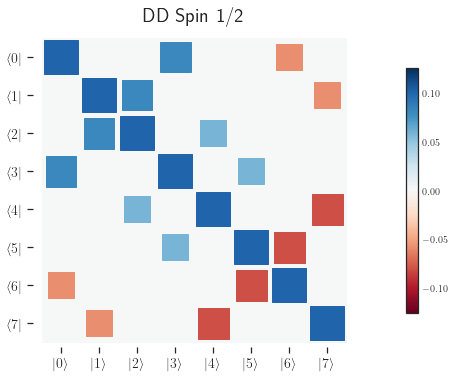

In [1404]:
DD_res = 50.5*1/(Fh_dn+Fh_up)
tau = DD_res[0]
ni=2
A = np.array([5, 5])
B = np.array([6, 6])
ni=3
rho_dd = Gate_Nqbit_dd(fL, Azz[0:ni:2], Azx[0:ni:2], tau, 618, s1=0.5, s0=-0.5)
# rho_dd = Gate_Nqbit_dd(fL, Azz[0:2], Azx[0:2], tau, 602, s1=0.5, s0=-0.5)
fig, ax = qt.visualization.hinton(rho_dd,
#                                   xlabels=['000','001','010','011','100','101','110','111'],
#                                   ylabels=['000','001','010','011','100','101','110','111'],
                                 label_top = False)
ax.set_title('DD Spin 1/2', fontsize=20)

(<Figure size 576x432 with 2 Axes>, <AxesSubplot: >)

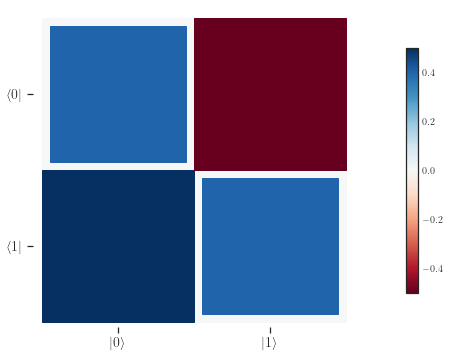

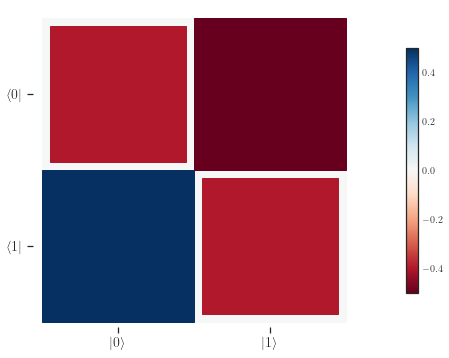

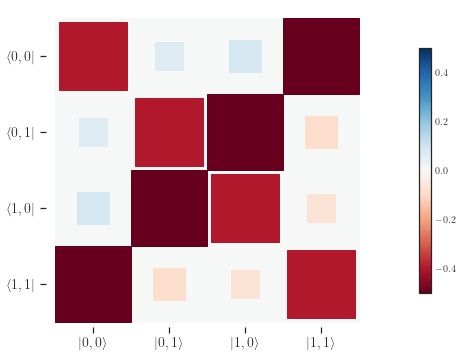

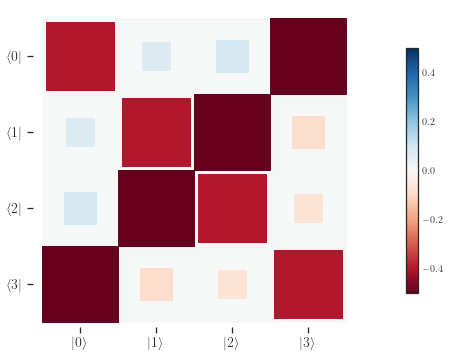

In [1223]:
A = qt.Qobj([[ 0.0355317-3.75225776e-04j,  0.3480267+9.36810958e-01j],
 [-0.3480267+9.36810958e-01j,  0.0355317+3.75225776e-04j]])/2
qt.visualization.hinton(A, label_top = False)
B = qt.Qobj([[-0.06165707-4.79436208e-04j,  0.3401552 +9.38345680e-01j],
 [-0.3401552 +9.38345680e-01j, -0.06165707+4.79436208e-04j]])/2
qt.visualization.hinton(B, label_top = False)
qt.visualization.hinton(qt.tensor(A,B)+qt.tensor(A.dag(),B.dag()), label_top = False)
AB = qt.Qobj([[-0.00054774+1.52503486e-06j,  0.0031096 +8.30334570e-03j,
  -0.00525229-1.44819697e-02j, -0.19016736+1.61307618e-01j],
 [-0.00293355+8.36716320e-03j, -0.00054765+1.00426268e-05j,
  -0.2493589 +1.97705876e-03j, -0.00547686-1.43985414e-02j],
 [ 0.00547686-1.43985414e-02j, -0.2493589 -1.97705876e-03j,
  -0.00054765-1.00426268e-05j,  0.00293355+8.36716320e-03j],
 [-0.19016736-1.61307618e-01j,  0.00525229-1.44819697e-02j,
  -0.0031096 +8.30334570e-03j, -0.00054774-1.52503486e-06j]])
qt.visualization.hinton(AB+AB.dag(), label_top = False)

In [1200]:
qt.tensor(A,B)-qt.tensor(A.dag(),B.dag())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.        +3.05006921e-06j  0.00604315+1.66705086e-02j
  -0.01072915-2.88805094e-02j  0.        +0.00000000e+00j]
 [-0.00604315+1.66705086e-02j  0.        +2.00852527e-05j
   0.        +0.00000000e+00j -0.01072915-2.88805094e-02j]
 [ 0.01072915-2.88805094e-02j  0.        +0.00000000e+00j
   0.        -2.00852527e-05j  0.00604315+1.66705086e-02j]
 [ 0.        +0.00000000e+00j  0.01072915-2.88805094e-02j
  -0.00604315+1.66705086e-02j  0.        -3.05006921e-06j]]

In [1201]:
AB-AB.dag()

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.        +3.05006972e-06j  0.00604315+1.66705089e-02j
  -0.01072915-2.88805111e-02j  0.        +0.00000000e+00j]
 [-0.00604315+1.66705089e-02j  0.        +2.00852536e-05j
   0.        +0.00000000e+00j -0.01072915-2.88805111e-02j]
 [ 0.01072915-2.88805111e-02j  0.        +0.00000000e+00j
   0.        -2.00852536e-05j  0.00604315+1.66705089e-02j]
 [ 0.        +0.00000000e+00j  0.01072915-2.88805111e-02j
  -0.00604315+1.66705089e-02j  0.        -3.05006972e-06j]]

# for DDESEEM gate

In [1568]:
def Gate_2qbit_ddeseem(fL, Azz, Azx, tau, tc1, tc2, N, s1=0.5, s0=-0.5): ## N must be even, Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 /=np.sqrt(np.sum(n_VD0*n_VD0,axis=0))

    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 /=np.sqrt(np.sum(n_VD1*n_VD1,axis=0))
    
    
    for i, azz in enumerate(Azz): 
        VD0 = np.array([ang_VD0[i], n_VD0[0,i], n_VD0[1,i], n_VD0[2,i]])
        VD1d = np.array([ang_VD0[i], -n_VD1[0,i], -n_VD1[1,i], -n_VD1[2,i]])
        VD0VD1d= mulVec(VD0, VD1d)
        print('Rot angle of nuc {}'.format(i)+'= {} deg'.format(VD0VD1d[0]*180/pi))
        
        tc= tc1
        F0 = np.array([Ome0[i]*tc/2, mx[i], 0, mz[i]])
        F1 = np.array([Ome1[i]*tc/2, nx[i], 0, nz[i]])
        F0d = np.array([Ome0[i]*tc/2, -mx[i], 0, -mz[i]])
        F1d = np.array([Ome1[i]*tc/2, -nx[i], 0, -nz[i]])
        F1VD0VD1dF1d = mulVec(mulVec(F1, VD0VD1d), F1d)
        F0VD0VD1dF0d = mulVec(mulVec(F0, VD0VD1d), F0d)
#         print(Uop(F1VD0VD1dF1d))

        tc= tc2
        F0 = np.array([Ome0[i]*tc/2, mx[i], 0, mz[i]])
        
        F1 = np.array([Ome1[i]*tc/2, nx[i], 0, nz[i]])
        F0d = np.array([Ome0[i]*tc/2, -mx[i], 0, -mz[i]])
        F1d = np.array([Ome1[i]*tc/2, -nx[i], 0, -nz[i]])
        F0F1VD0VD1dF1dF0d = mulVec(mulVec(F0, F1VD0VD1dF1d), F0d)
        F1F0VD0VD1dF0dF1d = mulVec(mulVec(F1, F0VD0VD1dF0d), F1d)
#         print(Uop(F0F1VD0VD1dF1dF0d))
        F0F1VD0VD1dF1dF0d_op = qt.Qobj(Uop(F0F1VD0VD1dF1dF0d))
        F1F0VD0VD1dF0dF1d_op = qt.Qobj(Uop(F1F0VD0VD1dF0dF1d))
        if i==0:
            F0F1VD0VD1dF1dF0d_s = F0F1VD0VD1dF1dF0d_op/2
            F1F0VD0VD1dF0dF1d_s = F1F0VD0VD1dF0dF1d_op/2
            Id = qt.identity(2)/2
        else:
            F0F1VD0VD1dF1dF0d_s = qt.tensor(F0F1VD0VD1dF1dF0d_s, F0F1VD0VD1dF1dF0d_op/2)
            F1F0VD0VD1dF0dF1d_s = qt.tensor(F1F0VD0VD1dF0dF1d_s, F1F0VD0VD1dF0dF1d_op/2)
            Id = qt.tensor(Id, qt.identity(2)/2)
    F0F1VD0VD1dF1dF0d_s_dag = F0F1VD0VD1dF1dF0d_s.dag()
    F1F0VD0VD1dF0dF1d_s_dag = F1F0VD0VD1dF0dF1d_s.dag()
    dim = len(Azz)
    rho = np.identity(2*2**dim, dtype=complex)
    rho[0     :2**dim,  0     :2**dim]  = (4*Id -1j*(F0F1VD0VD1dF1dF0d_s-F0F1VD0VD1dF1dF0d_s_dag) +1j*(F1F0VD0VD1dF0dF1d_s-F1F0VD0VD1dF0dF1d_s_dag))/8
    rho[0     :2**dim,  2**dim:2*2**dim]= -(1j*(F0F1VD0VD1dF1dF0d_s-F0F1VD0VD1dF1dF0d_s_dag) +1j*(F1F0VD0VD1dF0dF1d_s-F1F0VD0VD1dF0dF1d_s_dag))/8
    rho[2**dim:2*2**dim,0     :2**dim]  = -(1j*(F0F1VD0VD1dF1dF0d_s-F0F1VD0VD1dF1dF0d_s_dag) +1j*(F1F0VD0VD1dF0dF1d_s-F1F0VD0VD1dF0dF1d_s_dag))/8
    rho[2**dim:2*2**dim,2**dim:2*2**dim]= (4*Id -1j*(F0F1VD0VD1dF1dF0d_s-F0F1VD0VD1dF1dF0d_s_dag) +1j*(F1F0VD0VD1dF0dF1d_s-F1F0VD0VD1dF0dF1d_s_dag))/8
    return qt.Qobj(rho)

In [1569]:
def Gate_Nqbit_ddeseem(fL, Azz, Azx, tau, Tc, N, s1=0.5, s0=-0.5): ## N must be even, Azz and Azx are np.array
    # Tc is a list of times that pi pulses happens
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 /=np.sqrt(np.sum(n_VD0*n_VD0,axis=0))

    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 /=np.sqrt(np.sum(n_VD1*n_VD1,axis=0))
    
    
    for i, azz in enumerate(Azz): 
        VD0 = np.array([ang_VD0[i], n_VD0[0,i], n_VD0[1,i], n_VD0[2,i]])
        VD1d = np.array([ang_VD0[i], -n_VD1[0,i], -n_VD1[1,i], -n_VD1[2,i]])
        VD0VD1d= mulVec(VD0, VD1d)
        F1VD0VD1dF1d = F0VD0VD1dF0d = VD0VD1d
        print('Rot angle of nuc {}'.format(i)+'= {} deg'.format(VD0VD1d[0]*180/pi))
        for ind, tc in enumerate(Tc):
            n_pulse = ind+1
            F0 = np.array([Ome0[i]*tc/2, mx[i], 0, mz[i]])
            F1 = np.array([Ome1[i]*tc/2, nx[i], 0, nz[i]])
            F0d = np.array([Ome0[i]*tc/2, -mx[i], 0, -mz[i]])
            F1d = np.array([Ome1[i]*tc/2, -nx[i], 0, -nz[i]])
            if n_pulse%2==1:
                F1VD0VD1dF1d = mulVec(mulVec(F1, F1VD0VD1dF1d), F1d)
                F0VD0VD1dF0d = mulVec(mulVec(F0, F0VD0VD1dF0d), F0d)
            else:
                F1VD0VD1dF1d = mulVec(mulVec(F0, F1VD0VD1dF1d), F0d)
                F0VD0VD1dF0d = mulVec(mulVec(F1, F0VD0VD1dF0d), F1d)
        

#         print(Uop(F0F1VD0VD1dF1dF0d))

        F1VD0VD1dF1d_op = qt.Qobj(Uop(F1VD0VD1dF1d))
        F0VD0VD1dF0d_op = qt.Qobj(Uop(F0VD0VD1dF0d))
        if i==0:
            F1VD0VD1dF1d_s = F1VD0VD1dF1d_op/2
            F0VD0VD1dF0d_s = F0VD0VD1dF0d_op/2
            Id = qt.identity(2)/2
        else:
            F1VD0VD1dF1d_s = qt.tensor(F1VD0VD1dF1d_s, F1VD0VD1dF1d_op/2)
            F0VD0VD1dF0d_s = qt.tensor(F0VD0VD1dF0d_s, F0VD0VD1dF0d_op/2)
            Id = qt.tensor(Id, qt.identity(2)/2)
    F1VD0VD1dF1d_s_dag = F1VD0VD1dF1d_s.dag()
    F0VD0VD1dF0d_s_dag = F0VD0VD1dF0d_s.dag()
    dim = len(Azz)
    rho = np.identity(2*2**dim, dtype=complex)
    rho[0     :2**dim,  0     :2**dim]  = (4*Id -1j*(F1VD0VD1dF1d_s-F1VD0VD1dF1d_s_dag) +1j*(F0VD0VD1dF0d_s-F0VD0VD1dF0d_s_dag))/8
    rho[0     :2**dim,  2**dim:2*2**dim]= -(1j*(F1VD0VD1dF1d_s-F1VD0VD1dF1d_s_dag) +1j*(F0VD0VD1dF0d_s-F0VD0VD1dF0d_s_dag))/8
    rho[2**dim:2*2**dim,0     :2**dim]  = -(1j*(F1VD0VD1dF1d_s-F1VD0VD1dF1d_s_dag) +1j*(F0VD0VD1dF0d_s-F0VD0VD1dF0d_s_dag))/8
    rho[2**dim:2*2**dim,2**dim:2*2**dim]= (4*Id -1j*(F1VD0VD1dF1d_s-F1VD0VD1dF1d_s_dag) +1j*(F0VD0VD1dF0d_s-F0VD0VD1dF0d_s_dag))/8
    return qt.Qobj(rho)

Rot angle of nuc 0= 90.84319906697955 deg
Rot angle of nuc 1= 90.84319906697955 deg


Text(0.5, 1.0, 'DDESEEM Spin 1/2')

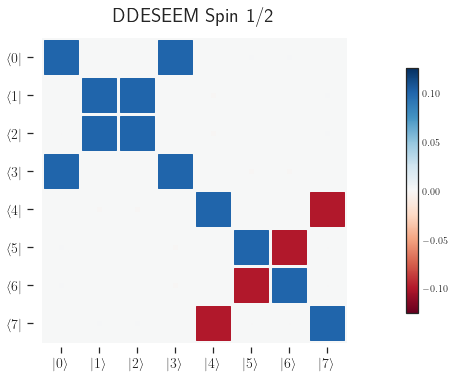

In [1578]:
DD_res = 50.5*1/(Fh_dn+Fh_up)
tau= DD_res[0]
tc1=5e-3
# tc2 = tc1+24.1554290755*112
# tc1 = 1.110145/4
tc2 =  tc1+0.024131*0
N=2900
ni=3
# rho_ddeseem = Gate_Nqbit_ddeseem(fL, Azz[0:ni:2], Azx[0:ni:2], tau, [tc1,tc2]*1, N, s1=0.5, s0=-0.5)
A = np.array([Azz[0]]*2)
B = np.array([Azx[0]]*2)
rho_ddeseem = Gate_Nqbit_dd(fL, A, B, tau, N, s1=0.5, s0=-0.5)
# rho_ddeseem = Gate_2qbit_ddeseem(fL, Azz[0:2], Azx[0:2], tau, [tc1], N, s1=0.5, s0=-0.5)
fig, ax = qt.visualization.hinton(rho_ddeseem,
#                                   xlabels=['000','001','010','011','100','101','110','111'],
#                                   ylabels=['000','001','010','011','100','101','110','111'],
                                 label_top = False)
ax.set_title('DDESEEM Spin 1/2', fontsize=20)

In [1558]:
abs(rho_ddeseem[6,0])-0.10372954294102159

-3.9804531989928726e-08

In [1352]:
(rho_ddeseem*rho_ddeseem).tr()

0.042535189591880324

In [1565]:
A

array([-20.72, -20.72, -20.72])